In [1]:
# Setup the library
import pyrogue as pr
import os, sys
import matplotlib.pyplot as plt
import time
import numpy as np
import math
from scipy.optimize import curve_fit
import pprint
import inspect 

top_level=f'{os.getcwd()}/../'
rootTopLevel = top_level+'script/'
pr.addLibraryPath( rootTopLevel )

import setupLibPaths
import ePix320kM as devBoard

args = None

In [2]:
%run supportFunctions.ipynb
%run dataProcFunctions.ipynb

In [3]:
# ONLY RUN ONCE!
# Defining root
# If crashes, make sure the deve is correct.
root =  devBoard.Root(   
        top_level  = top_level,
        dev        = '/dev/datadev_1',
        pollEn     = False,
        initRead   = True,
        pciePgpEn  = False,
        justCtrl   = False,
        DDebugSize = 4000)
root.start()

# example showing a read
AxiVersion = root.Core.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

Root.Core.Si5345Pll.Page0.DataBlock.setPollInterval(1)
Start: Started zmqServer on ports 9099-9101
    To start a gui: python -m pyrogue gui --server='localhost:9099'
    To use a virtual client: client = pyrogue.interfaces.VirtualClient(addr='localhost', port=9099)
Root.Core.AxiVersion count reset called
###################################################
#             Firmware Version                    #
###################################################
Path         = Root.Core.AxiVersion
FwVersion    = 0x1000300
UpTime       = 13 days, 8:45:10
GitHash      = 0x9550c2a95f7e334393e52bfde914e26fb20f11b8
XilinxDnaId  = 0x400200000139d7204c81a145
FwTarget     = ePixHRM320k
BuildEnv     = Vivado v2023.1
BuildServer  = rdsrv314 (Ubuntu 20.04.6 LTS)
BuildDate    = Wed 17 Jan 2024 11:42:17 PM PST
Builder      = dnajjar
###################################################


In [4]:
# Useful short names
APP  = root.App
AXIV = root.Core.AxiVersion
ASICTOP = APP.AsicTop
TRIG = ASICTOP.TriggerRegisters
ASIC0 = APP.Mv2Asic[0]
ASIC1 = APP.Mv2Asic[1]
ASIC2 = APP.Mv2Asic[2]
ASIC3 = APP.Mv2Asic[3]
HSDAC = APP.Dac.FastDac 
PKREG0 = ASICTOP.DigAsicStrmRegisters0
PKREG1 = ASICTOP.DigAsicStrmRegisters1
PKREG2 = ASICTOP.DigAsicStrmRegisters2
PKREG3 = ASICTOP.DigAsicStrmRegisters3
BATCHER0 = ASICTOP.BatcherEventBuilder0
BATCHER1 = ASICTOP.BatcherEventBuilder1
BATCHER2 = ASICTOP.BatcherEventBuilder2
BATCHER3 = ASICTOP.BatcherEventBuilder3
DEBUG0 = root._dbg[0]
DEBUG1 = root._dbg[1]
DEBUG2 = root._dbg[2]
DEBUG3 = root._dbg[3]
DATARCV0 = root.DataReceiver0
DATARCV1 = root.DataReceiver1
DATARCV2 = root.DataReceiver2
DATARCV3 = root.DataReceiver3
FULLRATERCV0 = root.fullRateDataReceiver[0]
FULLRATERCV1 = root.fullRateDataReceiver[1]
FULLRATERCV2 = root.fullRateDataReceiver[2]
FULLRATERCV3 = root.fullRateDataReceiver[3]
DAC = APP.Dac
REGCTRL = ASICTOP.RegisterControlDualClock

In [5]:
# Configure clock to 168 MHz and configures all ASICS
root.InitASIC([4,1,1,1,1])

Rysync ASIC started
Init ASIC script started
Loading PLL configuration
Loading supply configuration
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k-thinSensor/software/notebook/..//config/ePixHRM320k_PowerSupply_Enable.yml
Loading lane delay configurations
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k-thinSensor/software/notebook/..//config/ePixHRM320k_75000018efb4ab01_SspMonGrp_carrier3.yml
Loading waveforms configuration
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k-thinSensor/software/notebook/..//config/ePixHRM320k_RegisterControl.yml
Loading batcher configurations
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m-320k-thinSensor/software/notebook/..//config/ePixHRM320k_BatcherEventBuilder.yml
Loading packet register configurations
Loading /afs/slac.stanford.edu/g/controls/development/users/dnajjar/sandBox/epix-hr-m

In [6]:
root.disableAndCleanAllFullRateDataRcv()
root.enableDataRcv(False)
root.enableDataDebug(False)

#run some triggers and exercise lanes and locks
frames = 100
rate = 5000

root.hwTrigger(frames, rate)

Stop Triggers command executed
Set Auto Trigger command executed
Start Auto Trigger command executed
Triggers sent: 100
Stop Triggers command executed


In [7]:
# Get locked lanes
time.sleep(3)
root.getLaneLocks()

# Disabled lanes in ASICS
for asicIndex in range(4) : 
    root.App.AsicTop.DigAsicStrmRegisters0.enable.set(True)
    print("ASIC{}: {:#x}".format(asicIndex, getattr(root.App.AsicTop, f"DigAsicStrmRegisters{asicIndex}").DisableLane.get()))

ASIC0: 0xffffff
ASIC1: 0xfffffa
ASIC2: 0xb6ffff
ASIC3: 0xfeffff
ASIC0: 0x20000
ASIC1: 0x10045
ASIC2: 0x490000
ASIC3: 0x540140


In [8]:
# Enable data receivers and run some triggers
root.enableDataRcv(True)
root.enableAllAsics(True)
for i in range (5):
    root.Trigger()
    
root.enableDataRcv(False)
root.enableAllAsics(False)

# Select which ASIC

In [9]:
ASIC = ASIC1
ASICNUM = 1
DATADEBUG= DEBUG1

root.enableAsic(ASICNUM, True)

# Fit functions

In [10]:
# Define the linear function
def linear_function(x, a, b):
    return a * x + b

def getResidualsLinFit(x,y):
    
    weights = np.exp(-(x - np.mean(x))**2 / (2 * np.std(x)**2))
    weights = np.nan_to_num(weights, nan=0, posinf=0, neginf=0)
    
    params, covariance = curve_fit(linear_function, x, y, sigma=1/weights, absolute_sigma=True)
    y_fit = linear_function(x, *params)
   
    y_fit = np.nan_to_num(y_fit, nan=0, posinf=0, neginf=0)

    return (y - y_fit)

def getGainLinFit(x,y):
    
    weights = np.exp(-(x - np.mean(x))**2 / (2 * np.std(x)**2))
    params, covariance = curve_fit(linear_function, x, y, sigma=1/weights, absolute_sigma=True)
#     y_fit = linear_function(x, *params)
       
    params[0] = np.nan_to_num(params[0], nan=0, posinf=0, neginf=0) 

    return params[0]

# Run the following two cells once at initialization
The first cell might fail, that's ok. Stop it, then run the second one. Repeat if necessary.

In [11]:
lanesHackTest(root, PKREG1, DATADEBUG)

PKREG.TimeoutCntLane[0]=0
PKREG.TimeoutCntLane[1]=0
PKREG.TimeoutCntLane[2]=0
PKREG.TimeoutCntLane[3]=0
PKREG.TimeoutCntLane[4]=0
PKREG.TimeoutCntLane[5]=0
PKREG.TimeoutCntLane[6]=0
PKREG.TimeoutCntLane[7]=0
PKREG.TimeoutCntLane[8]=0
PKREG.TimeoutCntLane[9]=0
PKREG.TimeoutCntLane[10]=0
PKREG.TimeoutCntLane[11]=0
PKREG.TimeoutCntLane[12]=0
PKREG.TimeoutCntLane[13]=0
PKREG.TimeoutCntLane[14]=0
PKREG.TimeoutCntLane[15]=0
PKREG.TimeoutCntLane[16]=0
PKREG.TimeoutCntLane[17]=0
PKREG.TimeoutCntLane[18]=0
PKREG.TimeoutCntLane[19]=0
PKREG.TimeoutCntLane[20]=0
PKREG.TimeoutCntLane[21]=0
PKREG.TimeoutCntLane[22]=0
PKREG.TimeoutCntLane[23]=0
Stop Triggers command executed
Stop Triggers command executed
Data Descrambled
(192, 384, 2048)
Delta Aquisition Counter: 2048
Number of frames received: (192, 384, 2048)


In [12]:
lanesHackDisable(root, PKREG1, DATADEBUG)

PKREG.TimeoutCntLane[0]=1
PKREG.TimeoutCntLane[1]=1
PKREG.TimeoutCntLane[2]=0
PKREG.TimeoutCntLane[3]=1
PKREG.TimeoutCntLane[4]=1
PKREG.TimeoutCntLane[5]=1
PKREG.TimeoutCntLane[6]=1
PKREG.TimeoutCntLane[7]=1
PKREG.TimeoutCntLane[8]=1
PKREG.TimeoutCntLane[9]=1
PKREG.TimeoutCntLane[10]=1
PKREG.TimeoutCntLane[11]=1
PKREG.TimeoutCntLane[12]=1
PKREG.TimeoutCntLane[13]=1
PKREG.TimeoutCntLane[14]=1
PKREG.TimeoutCntLane[15]=1
PKREG.TimeoutCntLane[16]=1
PKREG.TimeoutCntLane[17]=1
PKREG.TimeoutCntLane[18]=1
PKREG.TimeoutCntLane[19]=1
PKREG.TimeoutCntLane[20]=1
PKREG.TimeoutCntLane[21]=1
PKREG.TimeoutCntLane[22]=1
PKREG.TimeoutCntLane[23]=1
ASIC0: 0xffffff
ASIC1: 0xfffffa
ASIC2: 0xb6ffff
ASIC3: 0xfeffff
ASIC0: 0x20000
ASIC1: 0x10045
ASIC2: 0x490000
ASIC3: 0x540140


# Settings

In [13]:
# Set analog settings
setAnalogSettings(ASIC0)
setAnalogSettings(ASIC1)
setAnalogSettings(ASIC2)
setAnalogSettings(ASIC3)

# Set best settings - pipoclk delay
setBestSettings(REGCTRL,ASIC0, ASIC1, ASIC2, ASIC3)

# Starting point
ASIC.RefGenB.set(2)    #2 bits
ASIC.RefGenC.set(1)    #2 bits
ASIC.Ref_gen_d.set(2) # Set 'common-mode' voltage of S/H stage
ASIC.S2D_1_b.set(0)    #3 bits
ASIC.shvc_DAC.set(30)  #6 bits
ASIC.S2dDacBias.set(3)
ASIC.DHg.set(False)

# Testing
ASIC.RefGenB.set(1)    #2 bits
ASIC.RefGenC.set(1)    #2 bits
ASIC.Ref_gen_d.set(3) # Set 'common-mode' voltage of S/H stage
ASIC.S2D_1_b.set(1)    #3 bits
ASIC.shvc_DAC.set(30)  #6 bits
ASIC.S2dDacBias.set(3)
ASIC.DHg.set(True)

#sets HSDAC device
HSDAC.enable.set(True)
#reset status
HSDAC.WFEnabled.set(False)
HSDAC.waveformSource.set(0)
HSDAC.externalUpdateEn.set(False)
HSDAC.run.set(False)

#configure
HSDAC.rCStartValue.set(20000)
HSDAC.rCStopValue.set(45535)
HSDAC.rCStep.set(250) # < --- Do not change!
HSDAC.WFEnabled.set(True)
HSDAC.waveformSource.set(1)
HSDAC.externalUpdateEn.set(True)
HSDAC.run.set(True)
HSDAC.DacValue.set(0)

# Enable ADC calibration with external signal
ASIC.mTest.set(True)

# Print
settings = (ASIC.RefGenB.get(), ASIC.RefGenC.get(), ASIC.Ref_gen_d.get(), ASIC.S2D_1_b.get(), ASIC.shvc_DAC.get(), ASIC.S2dDacBias.get(), ASIC.DHg.get())
print(settings)

R0 Width set to 7.808uS
R0 Delay set to 1.280uS
Acq1 Width set to 3.584uS
Acq1 Delay set to 4.864uS
-------------------------
Baseline time:    3.5839999999999996 uS
Integration time: 3.584 uS
Sampling done at: 8.448 uS
-------------------------
ASIC configured
(1, 1, 3, 1, 30, 3, True)


# ADC Tuning procedure starts here

In [14]:
# Re-set the DAC value for each dataset
HSDAC.externalUpdateEn.set(False)
HSDAC.run.set(False)
HSDAC.DacValue.set(0)
HSDAC.externalUpdateEn.set(True)
HSDAC.run.set(True)

# Generate a list containing the dacValues in Volts
# We take only the first 980 
dacValuesV = np.linspace(0.0,65535.0,2048) / 65535 * 2.31 

# Get data
imgDesc = getFrames(DATADEBUG)
imgDesc = imgDesc[:,:,:]

Stop Triggers command executed
Stop Triggers command executed


KeyboardInterrupt: 

Plot some pixels to inspect... we should see somehow straight lines

In [ ]:
print(np.shape(imgDesc))
plt.plot(imgDesc[10,50,:])
plt.plot(imgDesc[100,50,:])
plt.plot(imgDesc[150,50,:])
plt.plot(imgDesc[10,150,:])
plt.plot(imgDesc[100,150,:])
plt.plot(imgDesc[150,150,:])
plt.xlabel('Arbitrary number')
plt.ylabel('ADC output [ADU]')
plt.grid()

Looking at the plot above, we need to 'crop' the range on the X axis (arbitrary number) so that we select a linear region of the ramp.

In [ ]:
rampXmin = 900
rampXmax = 1700

# Crop the DAC values
dacValuesV = dacValuesV[rampXmin:rampXmax]
# Crop the ramp data
imgDesc = imgDesc[:,:,rampXmin:rampXmax]

Now we should see straight lines in the plots...

In [ ]:
print(np.shape(imgDesc))
plt.plot(imgDesc[10,50,:])
plt.plot(imgDesc[100,50,:])
plt.plot(imgDesc[150,50,:])
plt.plot(imgDesc[10,150,:])
plt.plot(imgDesc[100,150,:])
plt.plot(imgDesc[150,150,:])
plt.xlabel('Arbitrary number')
plt.ylabel('ADC output [ADU]')
plt.grid()

# Plot ramps of all ADCs
Trying to plot all of them migh be too much though...

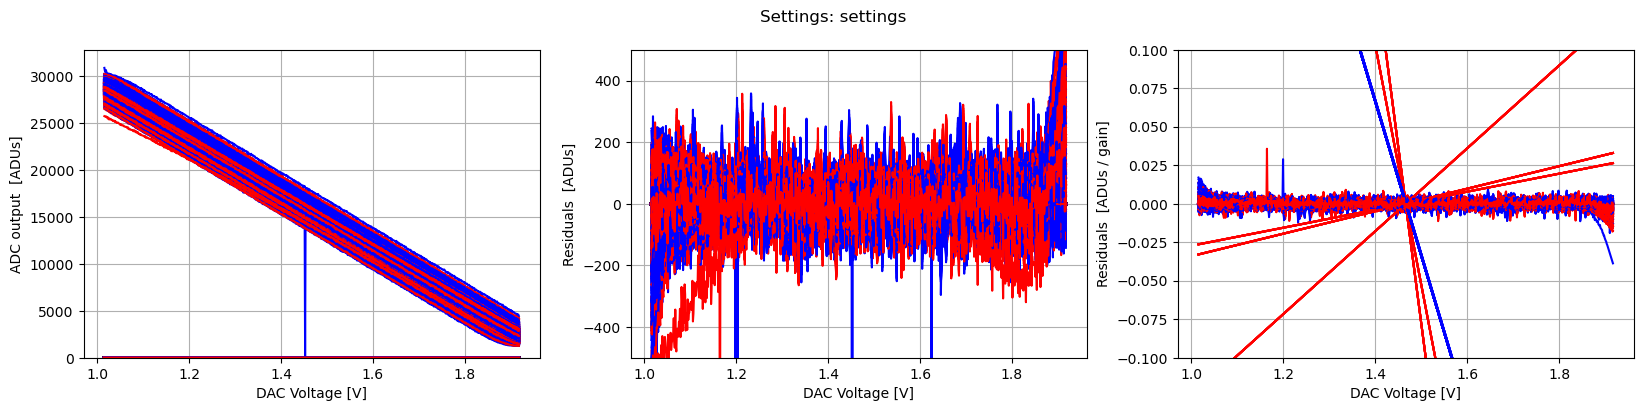

In [254]:
# Plot all, in odd/even fashion
col = 7
settings = "settings"
fig, axs = plt.subplots(1,3,figsize=(20,4))
plt.suptitle(('Settings: '+str(settings)))

axs[0].plot(dacValuesV,imgDesc[0,col,0:],label='Odd', c='blue')
axs[0].plot(dacValuesV,imgDesc[1,col,0:],label='Even', c='red')

for col in range(0,384,2):
    for row in range(0,192,48):
        axs[0].plot(dacValuesV,imgDesc[row,col,:], c='blue')
        axs[0].plot(dacValuesV,imgDesc[row+1,col,:], c='red')
        
axs[0].set_ylim(0,2**15)

axs[0].set_xlabel('DAC Voltage [V]')
axs[0].set_ylabel('ADC output  [ADUs]')
axs[0].grid()

for col in range(0,384,2):
    for row in range(0,192,48):
        gain = getGainLinFit(dacValuesV,imgDesc[row,col,:])
        if (gain == 0):
            gain= 1
        axs[1].plot(dacValuesV,getResidualsLinFit(dacValuesV,imgDesc[row,col,:]), c='blue')
        axs[1].plot(dacValuesV,getResidualsLinFit(dacValuesV,imgDesc[row+1,col,:]), c='red')

# plt.ylim(-1000,1000)
axs[1].set_xlabel('DAC Voltage [V]')
axs[1].set_ylabel('Residuals  [ADUs]')
axs[1].set_ylim(-500,500)

axs[1].grid()

for col in range(0,384,10):
    for row in range(0,192,48):
        gain = getGainLinFit(dacValuesV,imgDesc[row,col,:])
        if (gain == 0):
            gain= 1
        axs[2].plot(dacValuesV,getResidualsLinFit(dacValuesV,imgDesc[row,col,:])/gain, c='blue')
        axs[2].plot(dacValuesV,getResidualsLinFit(dacValuesV,imgDesc[row+1,col,:]/gain), c='red')

axs[2].set_xlabel('DAC Voltage [V]')
axs[2].set_ylabel('Residuals  [ADUs / gain]')
axs[2].set_ylim(-0.1,0.1)
axs[2].grid()

# Check pixels
Check how much of the ADC range we're using

In [255]:
# Set threshold to the minimum voltage (maximum energy, should not switch)
ASIC3.CompTH_ePixM.set(0)
# Enable ADC calibration with external signal
ASIC.mTest.set(False)

# Reference pixel
ref_row = 100
ref_col = 150

# Get ramps and calculate gain
ChInjValues, PixOutValues = chargeInjRamp(DATADEBUG, AsicNum=ASICNUM, Min=100, Max=1023, numSteps=20)

Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)
Data Descrambled
(192, 384, 1)


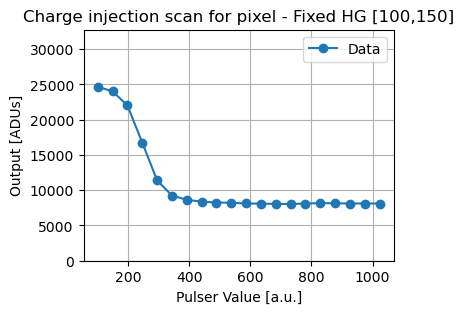

In [256]:
# Plot

plt.figure(figsize = (4,3))
plt.plot(ChInjValues, PixOutValues,'o-', label='Data')

plt.xlabel("Pulser Value [a.u.]")
plt.ylabel("Output [ADUs]")

plt.title('Charge injection scan for pixel - Fixed HG [{},{}]'.format(ref_row,ref_col))

# Limit Y-axis to ADC range
plt.ylim([0,2**15])

plt.legend()
plt.grid(True)

Stop Triggers command executed
Stop Triggers command executed
Data Descrambled
(192, 384, 2048)
Delta Aquisition Counter: 2048
Number of frames received: (192, 384, 2048)


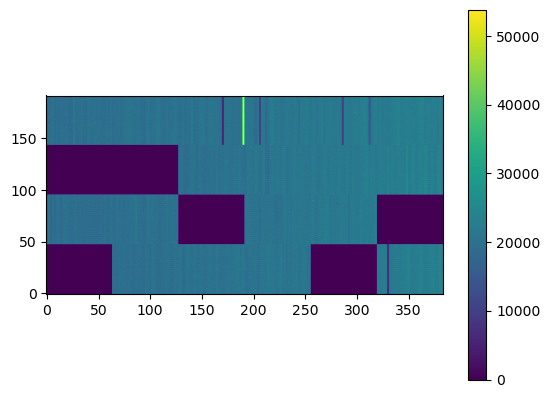

In [257]:
# Get data
dark = np.mean(getFrames(DATADEBUG), axis=2)

plt.imshow(dark[:,:], origin='lower')
plt.colorbar()

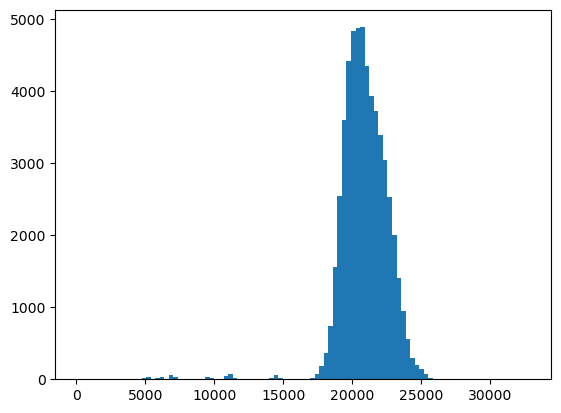

In [258]:
bins = np.linspace(100,2**15,100)
plt.hist(dark.flatten(), bins=bins);